In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
# import cupy as cp
import math
import time
import nbimporter
from Class_FEA import *
from Class_DataManipulation import *
import util_func
import matplotlib.pyplot as plt
from itertools import product
import subprocess as sp
import os
tf.keras.backend.set_floatx('float64')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from keras import callbacks

In [2]:
# Declare Abaqus job name, file path to job folder, and user subroutine name 
job_name = r"HGO_Tear_Propagation"
job_directory = r"D:\Users\Will\Tear_Propagation_Project"
umat_name = r"UMAT_HGO_C_Damage_Alpha"

# Declare work and data directories
work_directory = r"C:\Users\swilli9\Tear_Propagation_Project"
data_directory = r"{path}\Data_and_Visualizations".format(path=work_directory)

# Initialize FEA class to retrieve FEA information that is relevant to ROM
FE = Abaqus(job_name, job_directory, data_directory, BC_file=r"{path}\{job}_BC_mask.csv"
                      .format(path=data_directory,job=job_name))

# Define beta parameters
beta = np.array([[16.75, 40.78],
                 [26.11, 18.85],
                 [69.21, 63.20]])

# Initialize class for handling POD-BFGS functions and storing ROM data
data = FE_Data_M(beta, FE.data_path, FE.BC_mask)

# Initialize storage for time recording
offline_times = dict()
online_times = dict()

In [3]:
SVD_files = True

if not SVD_files:
    start = time.time()
    
    sigma, psi = data.get_POD_basis()
    
    end = time.time()
    
    offline_times["SVD"]= end-start
    
    pd.DataFrame(sigma).to_csv(r"{path}_Sigma.csv".format(path=data.data_path))
    pd.DataFrame(psi).to_csv(r"{path}_Psi.csv".format(path=data.data_path))
else:
    sigma = pd.read_csv(r"{path}_Sigma.csv".format(path=data.data_path), index_col=0).to_numpy()
    psi = pd.read_csv(r"{path}_Psi.csv".format(path=data.data_path), index_col=0).to_numpy()

cumulative_energy = np.cumsum(sigma)/np.sum(sigma)
high_energy_index = np.argwhere(cumulative_energy>=0.9999)[0]
l = int(5*np.ceil(high_energy_index / 5).item())

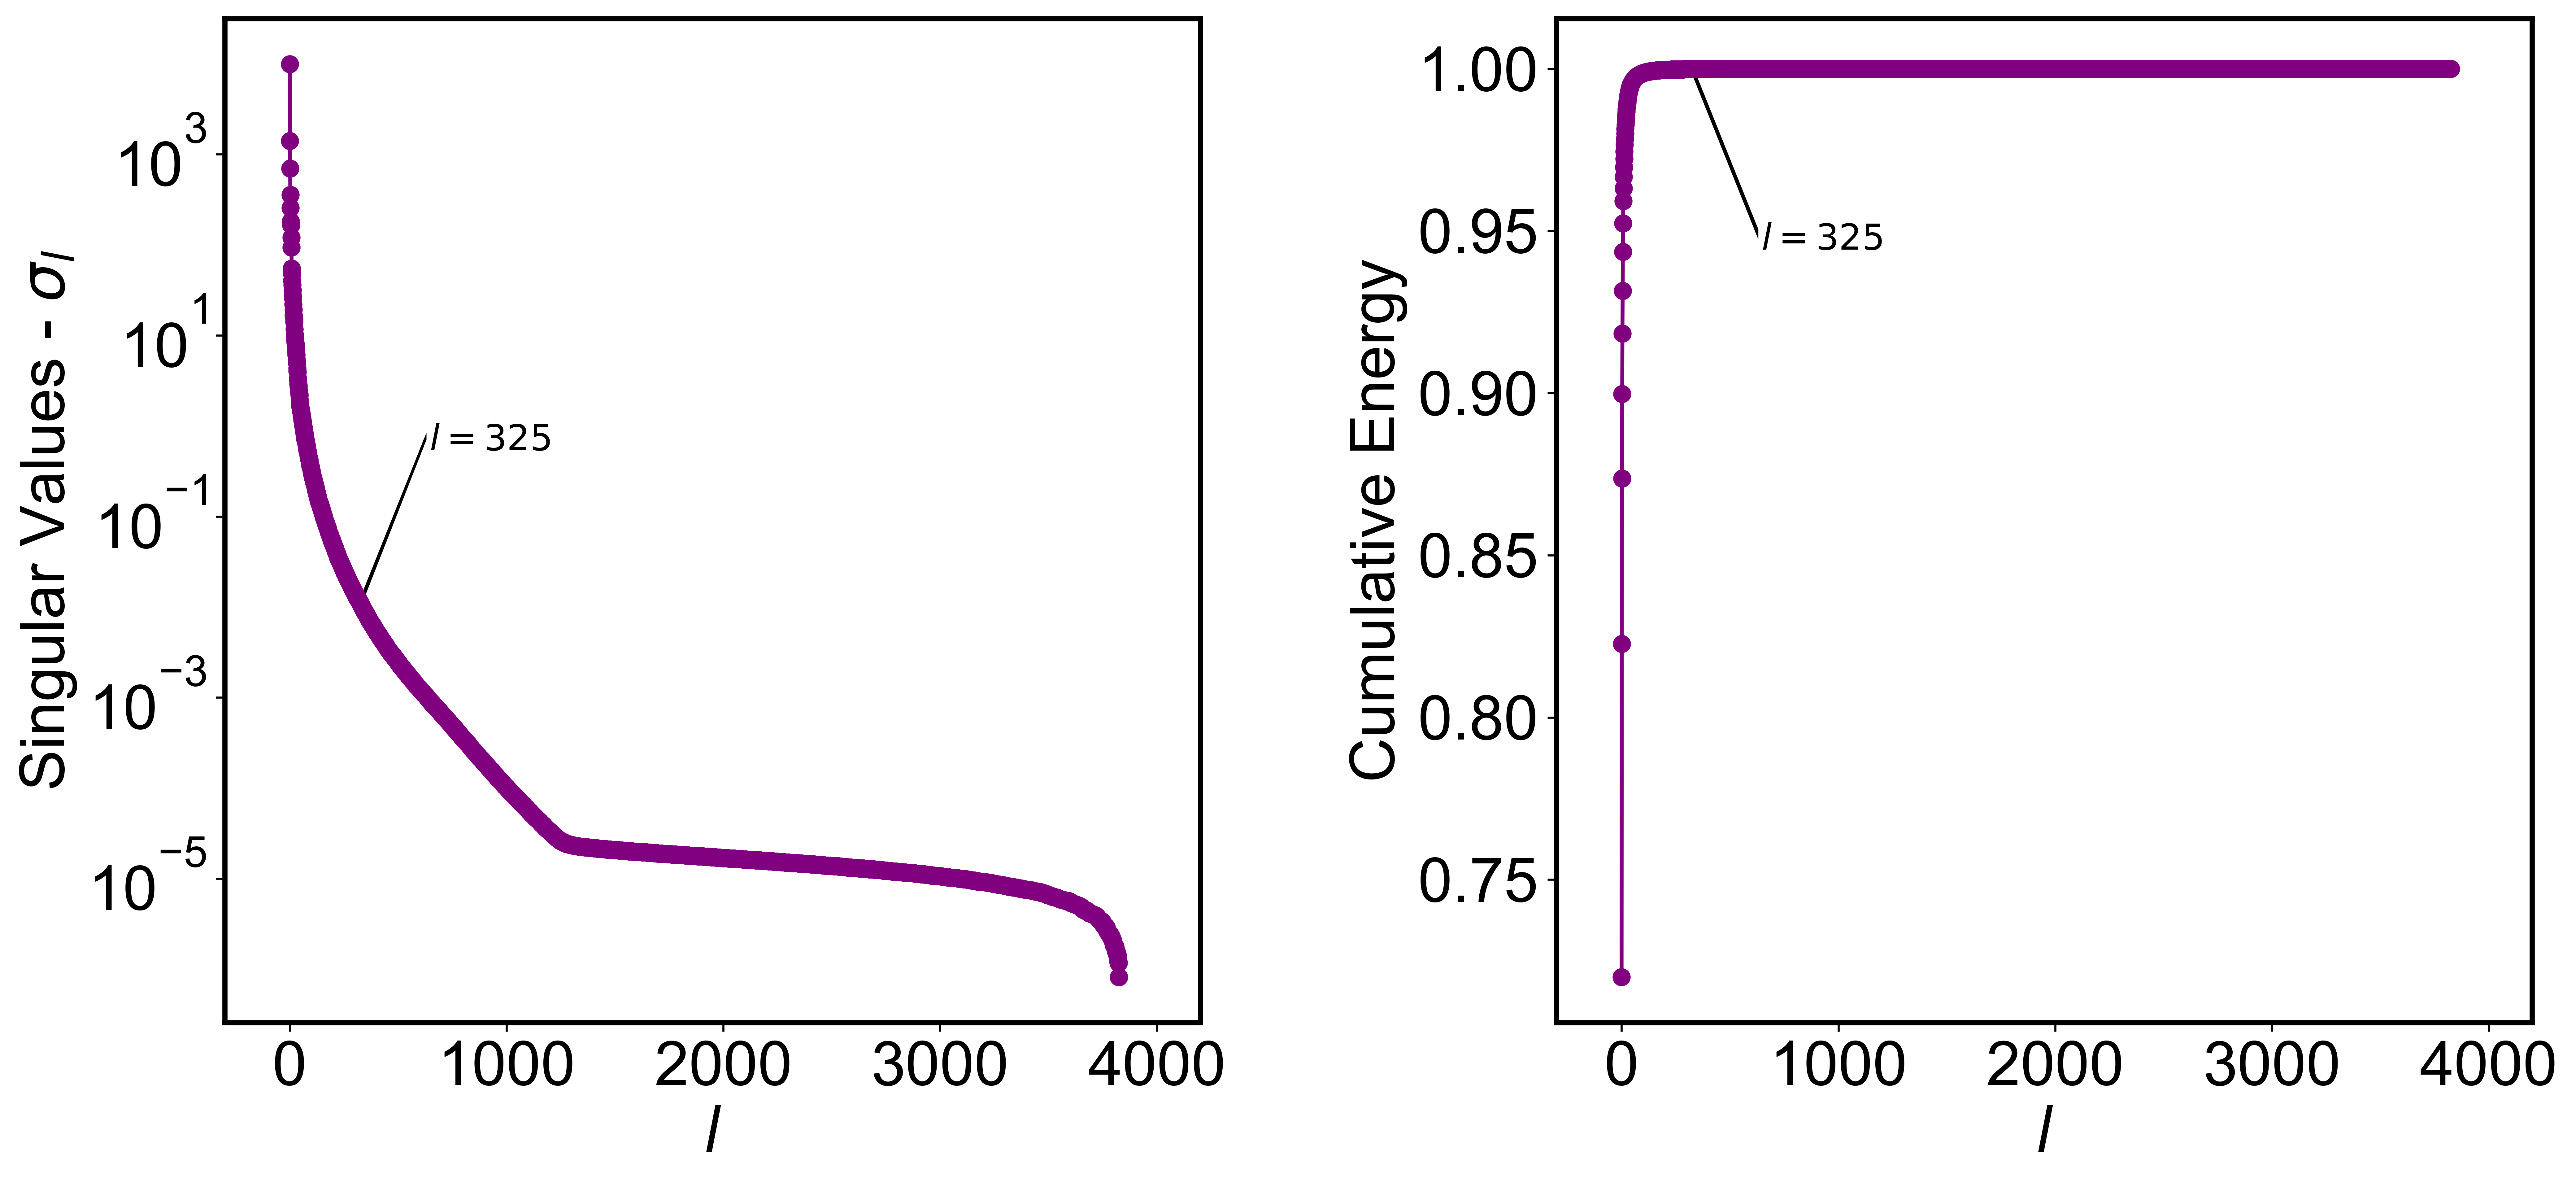

In [5]:
# Plot singular value decay and cumulative energy  
plt.rcParams.update({'font.size':24, 'axes.linewidth':2, 'font.family':'Arial'})

fig, ax = plt.subplots(1,2, figsize=(15,7.5), dpi=600)

ax[0].semilogy(sigma, color='#800080', marker='o', ms=6, mfc='#800080', mec='#800080', linestyle='-')

ax[1].plot(cumulative_energy, color='#800080', marker='o', ms=6, mfc='#800080', mec='#800080', linestyle='-')#, label=leg)

ax[0].arrow(l+300,sigma[325].item()+0.7,-300,-0.7)#l,cp.asnumpy(sigma)[325], l+1,cp.asnumpy(sigma)[325]-1e-4)
ax[1].arrow(l+300,cumulative_energy[325].item()-0.05,-300,+0.05)
ax[0].text(0.21, 0.57, r'$l=325$', transform=ax[0].transAxes, size=14)
ax[1].text(0.21, 0.77, r'$l=325$', transform=ax[1].transAxes, size=14)

ax[0].set_ylabel('Singular Values - $\sigma_{l}$')
ax[1].set_ylabel('Cumulative Energy')
for c in [0, 1]:
    ax[c].set_xlabel('$l$')
    ax[c].set_xlim([-300, 4200])
    ax[c].set_xticks(range(0,4001,1000))
#     ax[c].set_yticks([float(f'1e-{q}') for q in range(1,7)])
#     ax[c].set_ylim([float(f'5e-7'), float(f'2e-1')])
#     ax[c].legend(loc='best', fontsize=20, ncol=2, markerscale = 1.5, columnspacing=0.8, 
#              handletextpad=0.1, borderpad=0.3, framealpha=1, edgecolor='black')

fig.tight_layout(pad=2.0)
fig.savefig(r"{path}_sigma_decay_and_cumulative_energy.eps".format(path=data.data_path))


In [16]:
# K_red_file = False # Control whether K_red_0 is computed here or read from a pre-existing file

# if not K_red_file:
#     start = time.time()

#     K_red_0 = ROM.get_K_red_0(psi, l)

#     end = time.time()

#     offline_times["K_red_0"] = end-start

#     #K_red_0[0] = cp.squeeze(K_red_0[0])

#     #cp.savez("{path}_K_red_0".format(path=ROM.data_path), *K_red_0)
# else:
#     container = cp.load("{path}_K_red_0.npz".format(path=ROM.data_path))
#     K_red_0 = [container[key] for key in container.files]



In [ ]:
# combination = beta.shape[1]**beta.shape[0]
# zeta_list = [[None]*combination for i in range(l)]
# Uc_ROM = [cp.zeros_like(u) for u in ROM.Uc_mu]

# for i in range(1):
#     t = cp.array([ROM.times_mu[i]])
    
#     Fc_n = ROM.Fc_mu[i]
#     Fc = tf.constant(cp.hstack((cp.zeros_like(Fc_n),cp.matmul(Fc_n, t))))
    
#     Uc = tf.constant(cp.hstack((cp.zeros_like(Fc_n),ROM.Uc_mu[i])))
    
#     for k in range(1,2):
#         K_red_j_minus_1 = tf.constant(K_red_0[k][i])
        
#         I = tf.eye(k+1, dtype=tf.dtypes.float64)
        
#         Psi_l = tf.constant(psi[:,:k+1])
        
#         for j in range(1,2):#Fc.shape[1]+1):
#             du = tf.matmul(tf.transpose(Psi_l),Uc[:,j:j+1] - Uc[:,j-1:j])
#             dr = tf.matmul(tf.transpose(Psi_l), Fc[:,j:j+1] - Fc[:,j-1:j])
            
#             dudrT = tf.matmul(du, tf.transpose(dr))/tf.matmul(tf.transpose(dr), du)
#             drduT = tf.matmul(dr, tf.transpose(du))/tf.matmul(tf.transpose(du), du)
#             duduT = tf.matmul(du, tf.transpose(du))/tf.matmul(tf.transpose(dr), du) 
            
#             K_red_j_inv = tf.linalg.matmul(tf.linalg.matmul((I-drduT), 
#                                                             tf.linalg.inv(K_red_j_minus_1)),
#                                                             (I-dudrT)) + duduT
        
#             Fc_red = tf.matmul(tf.transpose(Psi_l),Fc[:,j:j+1])
            
#             zeta = tf.matmul(K_red_j_inv, Fc_red)
            
#             Uc_ROM[i][:,j-1:j] = tf.matmul(Psi_l,zeta).numpy()
            
#             print(Uc_ROM[i][:,j-1:j])
#             print(Uc[:,j-1:j])
        

In [ ]:
# Kc_0 = pd.read_csv(r"{path}_Kc0_{b_d}_{b_m}_{b_p}.csv"
#                                 .format(path=ROM.data_path,b_d=16.75,b_m=26.11,b_p=69.21), index_col=0).to_numpy()

# print((Kc_0.transpose() == Kc_0).all())

# ev = np.linalg.eigvals(Kc_0)

# print((ev > 0).all())

In [ ]:
# @tf.function
# def get_POD_basis(A):
#     #with tf.device('/GPU:0'):
#     covariance = tf.matmul(tf.transpose(A),A)

#     L, V = tf.linalg.eig(covariance)
#     Lambda = tf.sort(tf.math.real(L))[::-1]
#     L_arg = tf.argsort(tf.math.real(L))[::-1]

#     phi = tf.gather(tf.math.real(V), indices=L_arg, axis=1)

#     sigma = tf.math.sqrt(Lambda)
#     sigma = tf.where(tf.math.is_nan(sigma), tf.zeros_like(sigma), sigma)
# #         sigma_inv = cp.diag(sigma**-1)

# #         psi = cp.matmul(cp.matmul(A, phi[:, :sigma.shape[0]]), sigma_inv)

#     return sigma#, psi

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

print(get_gpu_memory())